In [1]:
import numpy as np
import os,math,cv2, h5py
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#load alex net and VGG-16
# download VGG-16 from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy and save under tf_models/
# download Alex Net from http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy and save under tf_models/

alex_net_path = os.path.join("tf_models/bvlc_alexnet.npy")
alex_net = np.load(alex_net_path, encoding='latin1').item()

vgg_net_path = os.path.join("tf_models/vgg16.npy")
vgg_net = np.load(vgg_net_path, encoding='latin1').item()
print(alex_net.keys())
print(vgg_net.keys())

dict_keys(['conv5', 'conv4', 'conv3', 'conv1', 'conv2', 'fc7', 'fc6', 'fc8'])
dict_keys(['conv3_3', 'conv3_2', 'conv4_1', 'conv4_2', 'conv5_3', 'fc7', 'conv3_1', 'fc8', 'conv5_1', 'conv1_2', 'conv1_1', 'conv2_1', 'conv5_2', 'conv2_2', 'conv4_3', 'fc6'])


In [3]:
a_c1 = alex_net['conv1']
w1 = a_c1[0]
b1 = a_c1[1]
print(w1.shape)

(11, 11, 3, 96)


In [4]:
#Needed for creating feature descriptors
def max_pool(input_x, kernel_size, stride, padding='VALID'):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input_x, ksize=ksize, strides=strides, padding=padding)

#Here we already have pre-trained weights
def conv_2d(input_x, weights, stride, bias=None, padding='VALID'):
    stride_shape = [1, stride, stride, 1]
    c = tf.nn.conv2d(input_x, weights, stride_shape, padding=padding)
    if bias is not None:
        c += bias
    return c
     

In [5]:

def imgread(path):
    print("Image:", path.split("/")[-1])
    # Read in the image using python opencv
    img = cv2.imread(path)
    img = img / 255.0
    print("Raw Image Shape: ", img.shape)
    
    # Center crop the image
    short_edge = min(img.shape[:2])
    W, H, C = img.shape
    to_crop = min(W, H)
    cent_w = int((img.shape[1] - short_edge) / 2)
    cent_h = int((img.shape[0] - short_edge) / 2)
    img_cropped = img[cent_h:cent_h+to_crop, cent_w:cent_w+to_crop]
    print("Cropped Image Shape: ", img_cropped.shape)
    
    # Resize the cropped image to 224 by 224 for VGG16 network
    img_resized = cv2.resize(img_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
    print("Resized Image Shape: ", img_resized.shape)
    return img_resized

In [6]:
#center crop and resize
image_path = os.path.join("images/corgi.jpg")
img1 = imgread(image_path)

#basic cv resize
img2 = cv2.imread(image_path)
img_resized = cv2.resize(img2, (224, 224), interpolation=cv2.INTER_LINEAR)

Image: corgi.jpg
Raw Image Shape:  (600, 900, 3)
Cropped Image Shape:  (600, 600, 3)
Resized Image Shape:  (224, 224, 3)


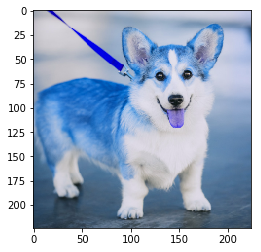

In [7]:
plt.imshow(img1)
plt.show()

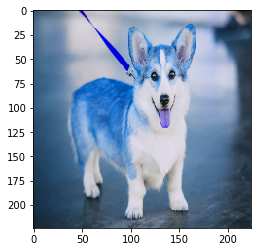

In [8]:
plt.imshow(img_resized)
plt.show()

In [9]:
#Testing Cell Block
ip = tf.Variable(tf.random_normal([1,3,3,5]))
ft = tf.Variable(tf.random_normal([1,1,5,1]))

op = tf.nn.conv2d(ip, ft, strides=[1, 1, 1, 1], padding='VALID')
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Usage passing the session explicitly.
    #print(op.eval(sess))
    #
    ip, op = sess.run([ip, op])
    print(op)


[[[[ 2.14689088]
   [ 1.00373304]
   [ 1.48730326]]

  [[-0.90294135]
   [ 0.55086225]
   [-1.49029779]]

  [[ 0.00264787]
   [-1.91101992]
   [ 2.06312156]]]]


In [10]:
#Testing Cell block
#For generating single descriptor from each convolution layer
tf.reset_default_graph()
images = tf.placeholder(tf.float32, [None, 224, 224, 3])
w = tf.get_variable('we', initializer=tf.to_float(w1))
print(images.get_shape(), w.get_shape())

c1 = conv_2d(images, w, 4, b1)
img1 = img1.reshape(1, 224, 224, 3) # convert to 4D tensor

(?, 224, 224, 3) (11, 11, 3, 96)


In [11]:
#Testing Cell block
#tf.reset_default_graph()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Usage passing the session explicitly.
    #print(op.eval(sess))
    #
    conv_op = sess.run([c1], feed_dict={images: img1})
    print(conv_op[0].shape)

(1, 54, 54, 96)


In [ ]:
def normalize(ip):
    m2 = np.min(ip)
    ip = ip - m2
    m1 = np.max(ip)
    ip = ip / m1
    return ip

In [ ]:
def alex_net_graph(ip, weights, biases):
    w1, w2, w3, w4, w5 = weights
    b1, b2, b3, b4, b5 = biases
    with tf.variable_scope("alex_net"):
        #CONV 1
        c1 = conv_2d(ip, w1, 4, b1, padding='VALID')
        r1 = tf.nn.relu(c1)
        m1 = max_pool(r1, 3, 2, padding='VALID')
        #print("M1", m1.get_shape)
        
        #CONV2
        m1 = tf.pad(m1, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT") # add 2 padding
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=m1)
        w2_1, w2_2 = tf.split(axis = 3, num_or_size_splits=2, value=w2)
        o1 = conv_2d(i1, w2_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w2_2, 1, bias=None, padding='SAME')
        c2 = tf.concat(axis = 3, values = [o1,o2])
        r2 = tf.nn.relu(c2)
        m2 = max_pool(r2, 3, 2, padding='VALID')
        #print("M2",m2.get_shape)
        
        #CONV3
        c3 = conv_2d(m2, w3, 1, b3)
        r3 = tf.nn.relu(c3)
        #print(r3.get_shape, "R3")
        
        #CONV4
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=r3)
        w4_1, w4_2 = tf.split(axis = 3, num_or_size_splits=2, value=w4)
        o1 = conv_2d(i1, w4_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w4_2, 1, bias=None, padding='SAME')
        c4 = tf.concat(axis = 3, values = [o1,o2])
        r4 = tf.nn.relu(c4)
        #print(r4.get_shape, "R4")
        
        #CONV5
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=r4)
        w5_1, w5_2 = tf.split(axis = 3, num_or_size_splits=2, value=w5)
        o1 = conv_2d(i1, w5_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w5_2, 1, bias=None, padding='SAME')
        c5 = tf.concat(axis = 3, values = [o1,o2])
        r5 = tf.nn.relu(c5)
        m5 = max_pool(r5, 3, 2, padding='VALID')
        #print(m5.get_shape, "M5")
        
        layers = [m1,m2,r3,r4,m5]
        return layers

        
        #c1 = conv_2d(ip, w1, 4, b1, padding='VALID')
        #print("C1", c1.get_shape)
        #c2 = conv_2d(c1, w2, 1, b2)
        


In [ ]:
#takes an input image and generates a feature descriptor from the image
def features_alex_net(inputs, alex_net):
    tf.reset_default_graph()
    H,W,D = 227, 227, 3
    
    w1, b1 = alex_net['conv1'][0], alex_net['conv1'][1]
    w2, b2 = alex_net['conv2'][0], alex_net['conv2'][1]
    w3, b3 = alex_net['conv3'][0], alex_net['conv3'][1]
    w4, b4 = alex_net['conv4'][0], alex_net['conv4'][1]
    w5, b5 = alex_net['conv5'][0], alex_net['conv5'][1]
    
    weights = [w1,w2,w3,w4,w5]
    biases = [b1,b2,b3,b4,b5]
    
    #print(w1.shape, w2.shape, w3.shape, w4.shape, w5.shape)
    
    images = tf.placeholder(tf.float32, [None, H, W, D])
    input_layers = alex_net_graph(images, weights, biases)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        result  = sess.run(input_layers, feed_dict={images: inputs})
        return result

In [ ]:
H,W,D = 227, 227, 3
i1 = cv2.imread(os.path.join("images/corgi.jpg"))
i1 = cv2.resize(i1, (H, W), interpolation=cv2.INTER_LINEAR)
i2 = cv2.imread(os.path.join("images/dog.png"))
i2 = cv2.resize(i2, (H, W), interpolation=cv2.INTER_LINEAR)
images = np.asarray([i1,i2])

conv1, conv2, conv3, conv4, conv5 = features_alex_net(images, alex_net)

In [ ]:
print(conv1.shape, conv2.shape, conv3.shape, conv4.shape, conv5.shape)

In [ ]:
print(np.amax(conv1, axis=(1,2)).shape)

In [ ]:
#apply max pooling per channel
# m1.. m5 are layer level image feature descriptors
m1 = np.amax(conv1, axis=(1,2))
m2 = np.amax(conv2, axis=(1,2))
m3 = np.amax(conv3, axis=(1,2))
m4 = np.amax(conv4, axis=(1,2))
m5 = np.amax(conv5, axis=(1,2))

In [ ]:
# as mentioned in paper, we get a vector of 1376
print(m1.shape, m2.shape)
r = np.concatenate((m1,m2,m3,m4,m5), axis=1)
print(r.shape)

In [ ]:
#add zero mean and normalization